## Variational Thermofield Double State Generation

In [189]:
# Importing all of the necessary dependencies

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from matplotlib import pyplot as plt
from qiskit import Aer, execute
import math
import random
import numpy as np
from scipy.optimize import minimize
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

**Introduction**

In this Notebook, we will turn our attention to a very import near-term application of quantum computers: generation of non-trivial quantum states for use in different experiments. The state that we will be looking into in this Notebook is called the <b>Thermofield Double State</b>, and is of great interest in areas of physics ranging from condensed matter to quantum chromodynamics, to black holes and gravitation. We will begin this Notebook by talking about what a Thermofield Doulbe State is, and some of its properties. We will then discuss a protocal for generating these states (see the Conclusion for the paper off of which this Notebook is based), and finally, we will simulate the generation of TFD states for two different Hamiltonians.

**Defining and Understanding the Thermofield Double State (TFD State)**

The goal of this Notebook is to outline a the variational process outlined [this paper]('https://arxiv.org/abs/1906.02699') in order to generate Thermofield Double States (TFD states), which are defined as follows:

<br>
$$|TFD\rangle \ = \ \frac{1}{\sqrt{Z(\beta)}} \displaystyle\sum_{n} e^{- \beta E_n / 2} |E_n\rangle_A \otimes |E_n'\rangle_B$$
<br>

Notice how we are concered with the tensor product of two states for each term in the sum (we are concerned with two different systems of qubits, register $A$ and register $B$). We also define $H_A$ to be the Hamiltonian governing the dynamics of the qubits in the first register, with $H_A |E_n\rangle_A \ = \ E_n |E_n\rangle_A$, thus making our TFD state depend on both the energy eigenstates and the energy eigenvalues. It is also important to note that $\beta$ is defined as the inverse temperature of the system that we are describing, $\beta \ = \ 1/T$. $Z(\beta)$ denotes the partition function, which is given by:

<br>
$$Z(\beta) \ = \ \displaystyle\sum_{n} e^{- \beta E_n}$$
<br>

Finally, we define $E_n'\rangle_B$ to be a vector in the state space described by the second qubit register, $B$, specifically, the time-reversed counterpart of $|E_n\rangle_A$:

<br>
$$|E_n'\rangle_B \ = \ \Theta |E_n\rangle_A \ = \ i Y K |E_n\rangle_A$$
<br>


Where $K$ is the complex conjugation operator. Consider the density matrix corresponding to the general TFD state:

<br>
$$\rho \ = \ |TFD\rangle \langle TFD| \ = \ \frac{1}{Z(\beta)} \displaystyle\sum_{m} \displaystyle\sum_{n} e^{-\beta (E_n \ + \ E_m)/2} |E_n\rangle \langle E_m|_A \ \otimes \ |E_n'\rangle \langle E_m'|_B$$
<br>

Now, what happens when we take the partial trace of the second register? Well, we get:

<br>
$$\rho_A \ = \ \frac{1}{Z(\beta)} \displaystyle\sum_{m} \displaystyle\sum_{n} e^{-\beta (E_n \ + \ E_m)/2} \text{Tr} \big( |E_n'\rangle \langle E_m'|_B \big) |E_n\rangle \langle E_m|_A$$
<br>

Now, let's quickly prove a nice result that will help us simplify this. We will demonstrate that the trace of the outer product of two orthogonal vectors is $0$. Since trace is indepedent of a chosen basis, we can take the trace with respect to the matrix representation of our outer product in the time-reversed energy basis, which ends up being:

<br>
$$\text{Tr}(|E_n'\rangle \langle E_m'|) \ = \ \displaystyle\sum_{j} \langle E_j' | E_n' \rangle \langle E_m' | E_j' \rangle$$
<br>

If $m \ \neq \ n$, this sum clearly is $0$, as each term of the sum is $0$. If $m \ = \ n$, we will get:

<br>
$$\displaystyle\sum_{j} \langle E_j' | E_n' \rangle \langle E_m' | E_j' \rangle \ = \ | \langle E_n' | E_n' \rangle |^2 \ = \ 1$$
<br>

Thus:

<br>
$$\text{Tr}(|E_n'\rangle \langle E_m'|) \ = \ \delta_{mn}$$
<br>

With $\delta_{mn}$ being the Kronecker Delta. Thus, we will have:

<br>
$$\rho_A \ = \ \frac{1}{Z(\beta)} \displaystyle\sum_{m} \displaystyle\sum_{n} e^{-\beta (E_n \ + \ E_m)/2} \delta_{mn} |E_n\rangle \langle E_m|_A \ = \ \frac{1}{Z(\beta)} \displaystyle\sum_{n} e^{-\beta E_n} |E_n\rangle \langle E_n|$$
<br>

Now, let's consider the matrix exponential of $H_A$, of the form $e^{-\beta H_A}$. We have:

<br>
$$H_A \ = \ \displaystyle\sum_{n} E_n |E_n\rangle \langle E_n|$$
<br>

Now, we will have:

<br>
$$e^{-\beta H_A} \ = \ \displaystyle\sum_{i \ = \ 0}^{\infty} \frac{1}{i!} \Big( \displaystyle\sum_{n} - \beta E_n  |E_n\rangle \langle E_n| \Big)^i$$
<br>

But since it is true that $|E_m\rangle \langle E_m| E_n \rangle \langle E_n| \ = \ 0$ when $m \ \neq \ n$, and $|E_n\rangle \langle E_n| E_n \rangle \langle E_n| \ = \ 1$ we will have:

<br>
$$\displaystyle\sum_{i \ = \ 0}^{\infty} \frac{1}{i!} \Big( \displaystyle\sum_{n} - \beta E_n  |E_n\rangle \langle E_n| \Big)^i \ = \ \displaystyle\sum_{i \ = \ 0}^{\infty} \frac{1}{i!} \Big( \displaystyle\sum_{n} (-\beta E_n)^i  (|E_n\rangle \langle E_n|)^i \Big) \ = \ \displaystyle\sum_{i \ = \ 0}^{\infty} \frac{1}{i!} \Big( \displaystyle\sum_{n} (- \beta E_n)^i  |E_n\rangle \langle E_n| \Big) \ = \ \displaystyle\sum_{n} \displaystyle\sum_{i \ = \ 0}^{\infty} \frac{(- \beta E_n)^i}{i!} |E_n\rangle \langle E_n \rangle \ = \ \displaystyle\sum_{n} e^{- \beta E_n} |E_n\rangle \langle E_n |$$
<br>

Which tells us that:

<br>
$$\rho_A \ = \ \frac{e^{-\beta H_A}}{Z(\beta)}$$
<br>

Which is exactly the <a href="https://en.wikipedia.org/wiki/Quantum_statistical_mechanics#Gibbs_canonical_ensemble">Gibbs state</a> for Hamiltonian $H_A$ and temperature $T \ = \ 1/ \beta$. This is a pretty interesting result. The original TFD generation paper recognizes this fact, and says that because of this fact, the TFD state is equivalent to a thermal state with an effective heat bath given by the $B$ register. From a "thermal perspective", we have a Gibbs state that is coupled to a collection of qubits. We initialize the 

Let's consider what happens to the TFD state as $T \ \rightarrow \ \infty$. This knowledge will become useful in the next section. Temperature approaching infinity implies that we have $\beta \ \rightarrow \ 0$. This gives us:

<br>
$$|TFD\rangle_{\beta = 0} \ = \ \frac{1}{\sqrt{Z(0)}} \displaystyle\sum_{n} |E_n\rangle \ \otimes \ |E_n'\rangle$$
<br>

But we also have:

<br>
$$Z(0) \ = \ \displaystyle\sum_{n} e^{0} \ = \ N$$
<br>

So this gives us:

<br>
$$|TFD\rangle_{\beta = 0} \ = \ \frac{1}{\sqrt{N}} \displaystyle\sum_{n} |E_n\rangle \ \otimes \ |E_n'\rangle$$
<br>

Which is simply an even superposition over tensor products of energy eigenstates and time-reversed energy eigenstates of the Hamiltonian of the system.

**The Variational Ansatz**

Now that we better understand what exactly the TFD state is, let's disucuss how we wopuld go about preparing it. The circuit we will be using is variational, meaning that we will repeatedly prepare a statevector parametrized by classical parameters, calculate the expectation value of some cost function with respect to the prepared state, and continue this process of preparing a state and calculating the cost function until we find the minimum value of the cost function, with a classical optimizer. We will discuss the cost function later in the Notebook.

The state preparation ansatz that is used in the paper is inspired by QAOA, in the sense that it involves alternating evolution between a "cost" unitary and a "mixer" unitary, mimicing Trotterized quantum adiabatic evolution, which in the limit of infinite depth will approach the ground state of the Hamiltonian of our system, $H_A \ + \ H_B$. We can then motivate the preparation of any TFD state from this approach, not just the case of the ground state with $T \ \rightarrow \ 0$, as the zero-temperature TFD state is generally harder to prepare than other finite temperature TFD states, due to the complexity of the correlations present in each of the qubit registers, thus our circuit should surely be able to learn the more "simple" correlations of the non-zero temperature states.

We can also motivate our ansatz from another, more "physical" perspective. As you will soon see, we will initialize the state of our qubits in an infinite-temperature state (that is maximally entangled). We can then think of the subsequent cost and mixer unitaries as "cooling" the infinite temperature state to the target temperature, with the cost unitary learning correlations within each register, while the mixer learns correlations between each register, each layer decoupling and lowering the effective temperature of the initially preparred thermal state.

With this knowledge, it is not too difficult to write down the exact form of our QAOA unitary, which will look something like this:

<br>
$$U(\boldsymbol\gamma, \boldsymbol\alpha) \ = \ \displaystyle\prod_{i \ = \ 1}^{P} e^{- i \alpha_i H_{C}} e^{- i \gamma_i (H_A \ + \ H_B)} \ = \ \displaystyle\prod_{i \ = \ 1}^{P} e^{- i \alpha_i H_{C}} e^{- i \gamma_i H_A} e^{-i \gamma_i H_B}$$
<br>

Where will will generally choose $H_C$ to be of the form:

<br>
$$H_C \ = \ \displaystyle\sum_{n} X^{A}_{n} X^{B}_{n} \ + \ Z^{A}_{n} Z^{B}_{n}$$ 
<br>

From here, it also becomes clear how we should initialize our qubits:

<br>
$$|\psi\rangle \ = \ \frac{|01\rangle \ - \ |10\rangle}{\sqrt{2}}$$
<br>

There are actually a few different ways to motivate this initialization. Firstly, the inter-register coupling Hamiltonian $H_C$ has this state as a ground state, which gives motivation from the QAOA and adiabatic quantum evolution perspective. In addition, this state represents an infinite temperature TFD state. The idea is that layered applications of unitaries will effectively cool, and "decouple" the qubits until they converge on the TFD state that we are attempting to prepare. Finally, the chosen Bell state is already set up in such a way that tracing out the $A$ register would simply leave, in $B$, a time-reversed copy of the state present in register $A$, which is analogous to the structure of the TFD state.

**The Time-Reversed Hamiltonian**

Now that we know the general structure of our variational circuit, all that follows is to figure out is a small detail that we have yet to consider: what exactly is $H_B$? Well, we know that $H_B$ will be the Hamiltonian that has $|E_n'\rangle \ = \ \Theta |E_n\rangle$ as eigenstates. It follows that $H_B$ can be written as:

<br>
$$H_B \ = \ -\Theta H_A \Theta$$
<br>

Since, given some $|E_n'\rangle$, we will have:

$$H_B |E_n'\rangle \ = \ -\Theta H_A \Theta |E_n'\rangle \ = \ \Theta H_A |E_n\rangle \ = \ \Theta E_n |E_n\rangle \ = \ E_n |E_n'\rangle$$

So the time-reversed states are eigenstates of this Hamiltonian. In addition, energy doesn't change under time-reversal, and as you can see, we retain the same energy $E_n$ for a given eigenstate under time-reversal, thus we have uniquely defined the time-reversed Hamiltonian!

Now, let's consider what happens when we put this Hamiltonian into our exponential unitary:

<br>
$$e^{-i \gamma H_B} \ = \ e^{i \gamma \Theta H_A \Theta} \ = \ \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{(i \gamma \Theta H_A \Theta)^n}{n!}$$
<br>

Now, here is the key realization: $-\Theta^2 \ = \ \mathbb{I}$, as time-reversing a quantum state twice is equivalent to doing nothing. Therefore, all of the middle terms in the product expansion of the numerator of each term will cancel, and we will have:

<br>
$$\displaystyle\sum_{n \ = \ 0}^{\infty} \frac{(i \gamma \Theta H_A \Theta)^n}{n!} \ = \ \displaystyle\sum_{n \ = \ 0}^{\infty} (-i Y K) \frac{(-i \gamma H_A )^n}{n!} (i Y K) \ = \ Y K \Big( \displaystyle\sum_{n \ = \ 0}^{\infty} \frac{(-i \gamma H_A )^n}{n!} \Big) Y K \ = \ Y K e^{-i \gamma H_A} Y K$$
<br>

Now, we have a bit of a problem. The complex conjugation is an <a href="https://en.wikipedia.org/wiki/Antilinear_map">antilinear map</a>, meaning there is no way to implement it as a gate on a quantum computer, where gates must correspond to linear unitary operators. This means that we will be forced to "throw out" the $K$s, leaving a unitary $U$ of the form:

<br>
$$U \ = \ Y e^{-i \gamma H_A} Y$$
<br>

For the first example, it can actually be found that the first $K$ on the right has no effect, as the circuit is depth $1$ and our initial state has no imaginary components. Nevertheless, this is not necessary true in the general case with multiple layers.

**A Simple Model**

We are going to start off by simulating the Thermofield Double State corresponding to a very simple uncoupled Hamiltonian of the form:

<br>
$$\hat{H}_X \ = \ \displaystyle\sum_{k} \ X_k$$
<br>

Where $X_k$ is a Pauli-X gate acting on the $k$-th qubit. This is a very simple model, but it provides a good place for us to start, to ensure that our simulations are functioning correctly, so we can eventually apply them to a more complex Ising model Hamiltonian.

We can begin by defining all of the necessary variables to run our simulation:

In [190]:
# Defines the variables that define the TFD state

beta = 1
testing_trials = 100
qubit_number = 3
depth = 1

Before we start building any quantum circuits, we are going to determine numerically what exactly our TFD state **should** look like, so we can ensure that our quantum circuit is outputting the correct state after we run our simulations.

We can begin by writing a method that gives us the matrix representation of $\hat{H}_X$ (in the computational basis) for any number of qubits:

In [191]:
# Calculates the cost Hamiltonian matrix for the X model

def calculate_x_matrix(qubit_number):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    # Creates the transverse field component of the matrix

    total_matrix = np.zeros((2**qubit_number, 2**qubit_number))

    for i in range(0, qubit_number):
        matrix = 1
        for k in range(0, qubit_number):
            if (k == i):
                matrix = np.kron(matrix, pauli_x)
            else:
                matrix = np.kron(matrix, identity)
        total_matrix = np.add(total_matrix, matrix)

    return total_matrix

And we can easily test it for a simple case:

In [192]:
h_x = calculate_x_matrix(qubit_number)
print(h_x)

[[0. 1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1. 0.]]


One can verify that this is the correct answer, but we will not show these calculations as it simply involves summing a few matrices together.

Recall that the TFD state is defined by the energy eigenvalues and eigenstates of the system in which it "exists". Thus, we will calculate the eignevalues and eigenvectors of the cost Hamiltonian, which we will eventually use to test our variational algorithm.

In [193]:
# Calculating the eigenvalues and eigenvectors of the cost Hamiltonian

def find_eigenvec_eigenval(matrix):

    value, vector = np.linalg.eig(matrix)

    new_vector = []
    for v in range(0, len(vector)):
        holder = []
        for h in range(0, len(vector)):
            holder.append(vector[h][v])
        new_vector.append(holder)

    return [value, np.array(new_vector)]

And now we can now utilize our method to find the energy eigenvalues/eigenstates (I'll only print out the eigenvalues, as the array storing the eigenvectors is fairly long):

In [194]:
ev = find_eigenvec_eigenval(hx4)
print(ev[0])

[ 4.00000000e+00+0.00000000e+00j -4.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j  5.28252698e-16+0.00000000e+00j
  2.00000000e+00+0.00000000e+00j  2.22044605e-16+0.00000000e+00j
  2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j  2.00000000e+00+0.00000000e+00j
  2.00000000e+00+0.00000000e+00j -8.41729930e-17+4.60483974e-17j
 -8.41729930e-17-4.60483974e-17j -2.00000000e+00+0.00000000e+00j
 -1.00988962e-16+9.74039235e-17j -1.00988962e-16-9.74039235e-17j]


With this newfound knowledge, we have all of the ingredients we need to create the TFD state corresponding to $\hat{H}_X$ (remember that we already defined $\beta$ earlier!). All we have to do is exponentiate $\beta$ along with each $E_n$, then take the squares of each of these values and sum them together to get the value of the partition function. Finally, we append each of the exponential values to each pair of energy eigenstates, and take the sum:

In [195]:
# Preaparing the partition function and each of the probability amplitudes of the diifferent terms in the TFD state

def calculate_terms_partition(eigenvalues):

    list_terms = []
    partition_sum = 0
    for i in eigenvalues:
        list_terms.append(math.exp(-0.5*beta*i))
        partition_sum = partition_sum + math.exp(-1*beta*i)

    return [list_terms, math.sqrt(float(partition_sum))]

The method above outputs each of the exponential terms, as well as the partiation function. Next, we will create a method that outputs the time evolution operator for a given $n$-qubit system:

In [196]:
#Preparring the TFD state for the cost function

def time_reversal(n):
    y_gate = 1
    
    y = np.array([[0, -1], [1, 0]])
    for i in range(0, qubit_number):
        y_gate = np.kron(y_gate, y)
    
    return y_gate

Finally, we can create the method that builds the TFD state:

In [197]:
# Constructs the TFD state

def construct_tfd_state(qubit_number, matrix_function):

    matrix = matrix_function(qubit_number)
    eigen = find_eigenvec_eigenval(matrix)
    partition = calculate_terms_partition(eigen[0])

    vec = np.zeros(2**(2*qubit_number))
    for i in range(0, 2**qubit_number):
        
        time_rev = time_reversal(qubit_number)
        time_rev = complex(0,1)*np.matmul(time_rev, np.conj(eigen[1][i]))
        
        addition = (float(partition[0][i]/partition[1]))*(np.kron(eigen[1][i], time_rev))
        vec = np.add(vec, addition)

    return vec

Now, we can visualize our state vector. One of the best ways to do this is by outputting a visual representation of the real component of the density matrix of the state. We can do this very easily with the help of a simple method:

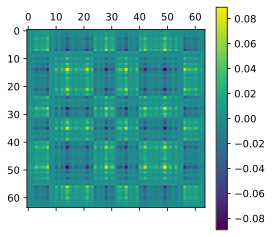

In [198]:
# Outputs a visual representation of a matrix

def create_density_plot(data):

    array = np.array(data)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

tfd = construct_tfd_state(qubit_number, calculate_x_matrix)
density_matrix = np.outer(tfd, np.conj(tfd))

create_density_plot(np.real(density_matrix))

Now that we know what our TFD state should look like, let's build our variational quantum circuit and see if we can prepare a state similar to the one shown above. We can begin by defining a method that will prepare our register of maximally entangled Bell pairs. Recall that the motivation for this setup is that we begin in a state such that the two registers are maximally coupled (where the coupling is "decreased" with subsequent unitary evolution), with a time-reversal operator applied to the second qubit register (as when the first qubit register is traced out, we want to be left with a time-reversed copy of the first qubit register).

We can begin our quantum simulation by writing the method that will initilize our $A$ and $B$ registers of qubits in maximally-entangled Bell pairs of the form:

<br>
$$\psi\rangle \ = \ \frac{|01\rangle \ - \ |10\rangle}{\sqrt{2}}$$
<br>



This is not too difficult, as we are simply implementing the standard protocal for generating Bell states, followed by the application of an $X$ gate and a $Z$ gate on the second qubit register:

In [199]:
# Generates the Bell state

def generate_bell_pairs(qubit_number, circ):
    
    q = int(qubit_number)
    
    for i in range(0, q):
        
        circ.h(i)
        circ.cx(i, q+i)
        circ.x(i)
        circ.z(i)

We can also take a look at exactly what this circuit looks like:

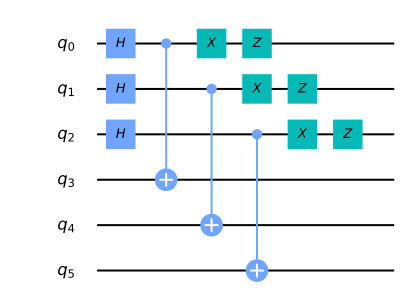

In [200]:
circ = QuantumCircuit(2*qubit_number)
generate_bell_pairs(qubit_number, circ)
circ.draw(output='mpl')

Like we described in the first part of this Notebook, we now want to evolve the registers of quibts in the QAOA-like fashion, alternating between Trotterized time-evolution with respect to $H_A$, and its time-reversed couterpart, $H_B$, and time-evolution with respect to a general coupling Hamiltonian, which has the Bell state as its ground state. In this case, we choose the coupling Hamiltonian to be of the form:

<br>
$$H_C \ = \ \displaystyle\sum_{n} X^{A}_{n} X^{B}_{n} \ + \ Z^{A}_{n} Z^{B}_{n}$$
<br>

Which one can check has the Bell state we previously prepared as its ground state. We can thus create two methods that will apply the two different time-evolution unitaries:

In [227]:
# Creates the "cost" time-evolution unitary

def x_cost_unitary(qubit_number, gamma, circ):
    
    # Applies the cost unitary to register A
    
    for i in range(0, qubit_number):
        circ.rx(gamma, i)
    
    # Applies the time-reversed cost unitary to register B
    
    for i in range(qubit_number, 2*qubit_number):
        
        circ.y(i)
        circ.rx(gamma, i)
        circ.y(i)

We can also test out this circuit to see what exactly it looks like:

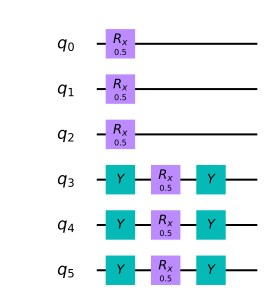

In [228]:
circ = QuantumCircuit(2*qubit_number)
x_cost_unitary(qubit_number, 0.5, circ)
circ.draw(output='mpl')

Now, we can create the mixer unitary, parametrized by $\alpha$. Notice how we are only using two parameters. This is due to the fact that the Hamiltonian we are simulating is relatively simple, so we shouldn't need a high-dimensional space of parameters in order to converge on the optimal solution.

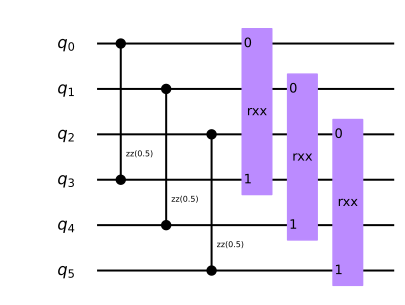

In [229]:
# Creates the "mixer" unitary layer

def x_mixer_unitary(qubit_number, alpha, circ):
    
    for i in range(0, qubit_number):
        
        circ.rzz(alpha, i, i+qubit_number)
        circ.rxx(alpha, i, i+qubit_number)

circ = QuantumCircuit(2*qubit_number)
x_mixer_unitary(qubit_number, 0.5, circ)
circ.draw(output='mpl')

We can then put this all together into a cost function, which will have parameters inputted, and will output the cost. For this first simulation, we will be doing a state vector simulation. We will be utilizing a state-overlap cost function, meaning that we will calculate the fidelity of the preparred state with respect to the numerical form of the TFD state that we found in the previous section:

<br>
$$F(\gamma, \alpha) \ = \ |\langle TFD | \psi (\gamma, \ \alpha)\rangle|^2$$
<br>

You may be thinking: "This cost function requires <i>a priori</i> knowledge of exactly what the TFD state is, so why even carry out this experiment in the first place?" Well, recall that the goal of this experiment isn't to <b>find out</b> what the TFD state is, but rather, <b>prepare it</b> in a register of qubits so it can be used for other experiments (TFD states are of great interest in many areas of physics, so experimenting with them on quantum processors might be a great way to perform experiments involving them). With this knowledge, our cost function will be of the form:

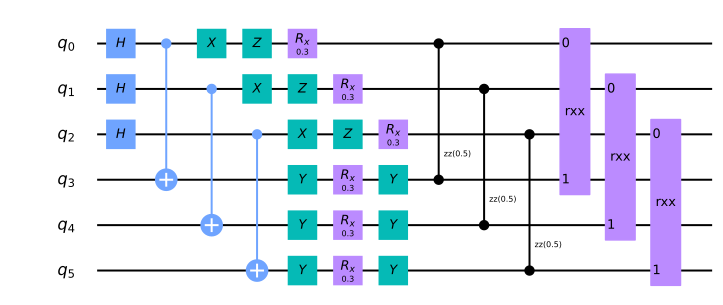

In [230]:
# Creates the full quantum circuit for arbitrary cost and unitary mixers

def full_circuit(gamma, alpha, qubit_number, depth, cost, mixer, circ):
    
    generate_bell_pairs(qubit_number, circ)
        
    for i in range(0, depth):
        
        cost(qubit_number, gamma[i], circ)
        mixer(qubit_number, alpha[i], circ)

circ = QuantumCircuit(2*qubit_number)
full_circuit([0.3], [0.5], qubit_number, 1, x_cost_unitary, x_mixer_unitary, circ)
circ.draw(output='mpl')

Finally, we can create the actual cost function:

In [236]:
# Creates the cost function

counter = 0

def cost_function(params):
    
    global counter
    circ = QuantumCircuit(2*qubit_number)
    
    full_circuit(params[0:1], params[1:2], qubit_number, 1, x_cost_unitary, x_mixer_unitary, circ)
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ, decimals=100)
    
    inner_prod = np.dot(np.conj(tfd), outputstate)
    fidelity = np.real(np.conj(inner_prod)*inner_prod)
    
    if (counter%50 == 0):
        print("Fidelity at Step "+str(counter)+": "+str(fidelity))
    
    counter += 1
    
    return (1-np.real(fidelity))

Now, we have everything we need to prepare our TFD state. Let's create the optimization method and run it!

Fidelity at Step 0: 0.8600087111641381
Fidelity at Step 50: 0.999999162788329


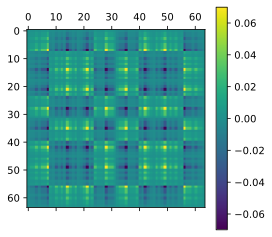

In [237]:
# Creates the optimizer

initial = [random.randint(-314, 314)/100 for i in range(0, 2)]
out = minimize(cost_function, x0=initial, method="COBYLA", options={'maxiter':200})

optimal_params = out['x']

# Finally, we create the visual representation of the density matrix of the preparred state

circ = QuantumCircuit(2*qubit_number)
full_circuit(optimal_params[0:1], optimal_params[1:2], qubit_number, 1, x_cost_unitary, x_mixer_unitary, circ)

backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
outputstate = result.get_statevector(circ, decimals=100)

final_density_matrix = np.outer(outputstate, np.conj(outputstate))
create_density_plot(np.real(final_density_matrix))

After only $50$ steps, the algorithm converged one the optimal state. If we compare the density matrix we generated above to the one we generated earlier in the Notebook, we see that they are identical!

**A Slightly More Complicated Hamiltonian: The Ising Model**

Now, with our simple example done, we can turn our attention to a system that is slightly more complicated (since it involves coupling between qubits). This is the Ising model Hamiltonian, which is given by:

<br>
$$H_I \ = \ \displaystyle\sum_{i} X_i X_{i+1} \ + \ \displaystyle\sum_{j} Z_j$$
<br>

We will follow a fairly similar process to what we did in the previous section. First, we will numerically generate the TFD state for a new value of inverse temperature, $\beta \ = \ 0.3$. We start by defining a method that outputs the matrix form (in the computational basis) of the Ising model Hamiltonian:

In [155]:
# Defines beta

beta = 0.3

# Defines a method that generates an Ising model Hamiltonian

def calculate_ising_matrix(qubit_number):

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    # Creates the transverse field component of the matrix

    total_matrix = np.zeros((2**qubit_number, 2**qubit_number))

    for i in range(0, qubit_number):
        matrix = 1
        for k in range(0, qubit_number):
            if (k == i or k == (i+1)%qubit_number):
                matrix = np.kron(matrix, pauli_x)
            else:
                matrix = np.kron(matrix, identity)
        total_matrix = np.add(total_matrix, matrix)
    
    for i in range(0, qubit_number):
        matrix = 1
        for k in range(0, qubit_number):
            if (k == i):
                matrix = np.kron(matrix, pauli_z)
            else:
                matrix = np.kron(matrix, identity)
        total_matrix = np.add(total_matrix, matrix)

    return total_matrix

For our system, this matrix will look like this:

In [156]:
h_ising = calculate_ising_matrix(qubit_number)
print(h_ising)

[[ 3.  0.  0.  1.  0.  1.  1.  0.]
 [ 0.  1.  1.  0.  1.  0.  0.  1.]
 [ 0.  1.  1.  0.  1.  0.  0.  1.]
 [ 1.  0.  0. -1.  0.  1.  1.  0.]
 [ 0.  1.  1.  0.  1.  0.  0.  1.]
 [ 1.  0.  0.  1.  0. -1.  1.  0.]
 [ 1.  0.  0.  1.  0.  1. -1.  0.]
 [ 0.  1.  1.  0.  1.  0.  0. -3.]]


Now, we can simply use the function that we defined previously to generate the density matrix plot of the TFD state corresponding to this Hamiltonian:

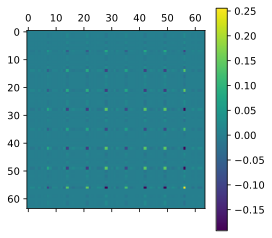

In [157]:
tfd = construct_tfd_state(qubit_number, calculate_ising_matrix)
density_matrix = np.outer(tfd, np.conj(tfd))

create_density_plot(np.real(density_matrix))

Unfortunately, this density matrix plot isn't as "exotic looking" as the first one. Now, we simply have to do another quantum simulation. Since we have already defined a lot of the machinery we need to make our simulation, all we have left to do is construct a new cost unitary. Before we do this, let us bring up an important fact from the TFD paper: the authors found that evolving the second qubit register with respect to the time-reversed Hamiltonian did not have a great effect on the convergence of the algorithm (it is often the case with parametrized algorithms that the degrees of freedom introduced by the parameters themselves allow circuit like QAOA, with physical motivation from AQC, to be truncated). Thus, we construct our cost unitary as follows:

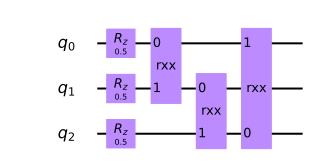

In [158]:
# Defines the new cost unitary for our Ising model

def ising_cost_unitary(qubit_number, gamma, circ):
    
    for i in range(0, qubit_number):
        circ.rz(gamma, i)
    
    for i in range(0, qubit_number):
        circ.rxx(gamma, i, (i+1)%qubit_number)

circ = QuantumCircuit(qubit_number)
ising_cost_unitary(qubit_number, 0.5, circ)
circ.draw(output='mpl')

Our complete circuit will look something like this:

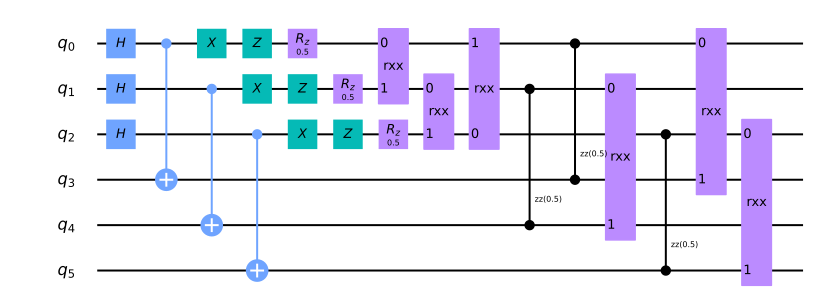

In [160]:
circ = QuantumCircuit(2*qubit_number)
full_circuit([0.5], [0.5], qubit_number, 1, ising_cost_unitary, x_mixer_unitary, circ)
circ.draw(output='mpl')

Now, we define our new quantum simulation. First, we define the new cost function, with the new circuit. For the case of this simulation, we are going to run our variational circuit with depth equal to $2$, and different values of $\gamma$ and $\alpha$ for the two layers. With a depth one circuit, we observed a fidelity of around $0.94$, whereas with depth two, we get a fidelity of around $0.99$.

In [167]:
# Creates the Ising model cost function

counter = 0

def cost_function(params):
    
    global counter
    circ = QuantumCircuit(2*qubit_number)
    
    full_circuit(params[0:2], params[2:4], qubit_number, 2, ising_cost_unitary, x_mixer_unitary, circ)
    
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ, decimals=100)
    
    inner_prod = np.dot(np.conj(tfd), outputstate)
    fidelity = np.real(np.conj(inner_prod)*inner_prod)
    
    if (counter%50 == 0):
        print("Fidelity at Step "+str(counter)+": "+str(fidelity))
    
    counter += 1
    
    return (1-np.real(fidelity))

Then, we create the optimizer and run the circuit:

Fidelity at Step 0: 0.0017350892842628604
Fidelity at Step 50: 0.9881497144911858
Fidelity at Step 100: 0.9884641848252027
Fidelity at Step 150: 0.9888675863415084


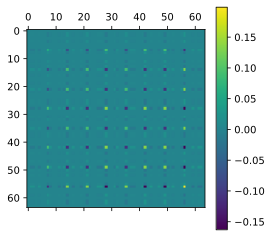

In [168]:
# Creates the optimizer

initial = [random.randint(-314, 314)/100 for i in range(0, 4)]
out = minimize(cost_function, x0=initial, method="COBYLA", options={'maxiter':200})

optimal_params = out['x']

# Finally, we create the visual representation of the density matrix of the preparred state

circ = QuantumCircuit(2*qubit_number)
full_circuit(optimal_params[0:2], optimal_params[2:4], qubit_number, 2, ising_cost_unitary, x_mixer_unitary, circ)

backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
outputstate = result.get_statevector(circ, decimals=100)

final_density_matrix = np.outer(outputstate, np.conj(outputstate))
create_density_plot(np.real(final_density_matrix))

Thus, one can see that it is in fact possible to generate the TFD state to a very high degree of accuracy, even with the removal of certain parts of the adiabatic ansatz and a relatively low circuit depth!

**Conclusion and Further Reading**

This Notebook was based off of the research done by D. Zhu, S. Johri, N. M. Linke, K. A. Landsman, N. H. Nguyen, C. H. Alderete, A. Y. Matsuura, T. H. Hsieh, and C. Monroe, presented in the paper: <i>Generation of Thermofield Double States and Critical Ground States with a Quantum Computer</i> (linked below).

If you're interested in learning more about TFD states, or their variational generation, check out the following papers:

- <a href="https://arxiv.org/pdf/1811.11528.pdf">How to Build the Thermofield Double State</a>
- <a href="https://arxiv.org/abs/1906.02699">Generation of Thermofield Double States and Critical Ground States with a Quantum Computer</a>

For an interesting application of TFD states, check out:

- <a href="https://arxiv.org/abs/1911.06314">Quantum Gravity in the Lab: Teleportation by Size and Traversable Wormholes</a>

Thank you to Tim Hsieh for answering my questions relating the TFD generation paper (of which he is one of the authors).

In [238]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}